In [1]:
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [2]:
#https://www.openml.org/d/31
credit_g = fetch_openml('credit-g', version=1)
credit_data = credit_g['data']
credit_data['target'] = credit_g['target']
credit_data.shape

(1000, 21)

In [3]:
## Create Missing Values
credit_data['duration'].iloc[0:46] = np.nan
credit_data['checking_status'].iloc[25:75] = np.nan
credit_data['credit_amount'].iloc[10:54] = 0

/Users/shanekercheval/opt/anaconda3/envs/python-examples/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
hlp.pandas.numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,954,46,5.0%,0,0.0%,20.9,12.0,0.6,1.1,1.0,4.0,9.0,12.0,18.0,24.0,36.0,72.0
credit_amount,"1,000",0,0.0%,44,4.0%,"3,132.9","2,853.4",0.9,1.9,4.3,0.0,740.0,"1,287.8","2,224.0","3,873.5","7,119.8","18,424.0"
installment_commitment,"1,000",0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,"1,000",0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,"1,000",0,0.0%,0,0.0%,35.5,11.4,0.3,1.0,0.6,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,"1,000",0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,"1,000",0,0.0%,0,0.0%,1.2,0.4,0.3,1.9,1.6,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [5]:
hlp.pandas.non_numeric_summary(credit_data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,950,50,0.050000,no checking,4,0.4%
credit_history,"1,000",0,0.000000,existing paid,5,0.5%
purpose,"1,000",0,0.000000,radio/tv,10,1.0%
savings_status,"1,000",0,0.000000,<100,5,0.5%
employment,"1,000",0,0.000000,1<=X<4,5,0.5%
personal_status,"1,000",0,0.000000,male single,4,0.4%
other_parties,"1,000",0,0.000000,none,3,0.3%
property_magnitude,"1,000",0,0.000000,car,4,0.4%
other_payment_plans,"1,000",0,0.000000,none,3,0.3%
housing,"1,000",0,0.000000,own,3,0.3%


# Training and Test Data

In [6]:
y_full = credit_data['target']
X_full = credit_data.drop(columns='target')

In [7]:
hlp.pandas.value_frequency(series=y_full)

,Frequency,Percent
good,700,0.7
bad,300,0.3


In [8]:
y_full[0:10]

0    good
1     bad
2    good
3    good
4     bad
5    good
6    good
7    good
8    good
9     bad
Name: target, dtype: category
Categories (2, object): ['good', 'bad']

In [9]:
from sklearn.preprocessing import label_binarize
y_full = label_binarize(y_full, classes=['bad', 'good']).flatten()

In [10]:
y_full[0:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [12]:
del y_full, X_full

In [13]:
print(X_train.shape)
print(len(y_train))

print(X_test.shape)
print(len(y_test))

(800, 20)
800
(200, 20)
200


In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [15]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

In [16]:
np.unique(y_test, return_counts=True)[1] / np.sum(np.unique(y_test, return_counts=True)[1])

array([0.295, 0.705])

# Transformation Pipeline

In [17]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [18]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [19]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute_chooser', hlp.sklearn.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling_chooser', hlp.sklearn.TransformerChooser()),
])

In [20]:
non_numeric_pipeline = Pipeline([
    ('encoder_chooser', hlp.sklearn.TransformerChooser()),
])

In [21]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric_columns),
    ('non_numeric_pipeline', non_numeric_pipeline, non_numeric_columns)
])

In [22]:
#pd.DataFrame(temp)

# Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [24]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    ('model', random_forest_model)
])

In [25]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'preparation': ColumnTransformer(transformers=[('numeric_pipeline',
                                  Pipeline(steps=[('impute_chooser',
                                                   TransformerChooser()),
                                                  ('scaling_chooser',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric_pipeline',
                                  Pipeline(steps=[('encoder_chooser',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                           

# Grid Search

In [26]:
param_grad = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [OneHotEncoder(),
                                                                                 hlp.sklearn.CustomOrdinalEncoder()],
        'model__max_features': [2, 10, 'auto'],
        'model__n_estimators': [50, 100, 500]
    },
]

In [27]:
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [28]:
num_folds = 5
num_repeats = 2

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
grid_search = GridSearchCV(full_pipeline,
                           param_grid=param_grad,
                           cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
                           scoring=scores,
                           refit='ROC/AUC',
                           #scoring='roc_auc',
                           return_train_score=True
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('numeric_pipeline',
                                                                         Pipeline(steps=[('impute_chooser',
                                                                                          TransformerChooser()),
                                                                                         ('scaling_chooser',
                                                                                          TransformerChooser())]),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'installment_commitment',
                                                       

## Results

In [30]:
grid_search_df = hlp.sklearn.cv_results_to_dataframe(searcher=grid_search,
                                                     num_folds=num_folds,
                                                     num_repeats=num_repeats,
                                                     return_style=False)

In [31]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
grid_search_df.rename(columns=column_new_names, inplace=True)

In [32]:
grid_search_df.head()

,ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,F1 Mean,F1 95CI.LO,F1 95CI.HI,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
32,0.762312,0.739291,0.785334,0.834676,0.821424,0.847928,0.764755,0.742526,0.786983,0.919683,0.909408,0.929959,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
8,0.762079,0.740679,0.783479,0.842079,0.829384,0.854774,0.748544,0.726245,0.770843,0.963687,0.952570,0.974804,2,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
33,0.761862,0.738940,0.784783,0.835590,0.822723,0.848457,0.765052,0.743336,0.786769,0.921448,0.911152,0.931745,auto,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
9,0.761622,0.740900,0.782345,0.843529,0.831564,0.855495,0.750270,0.728647,0.771893,0.964596,0.953692,0.975500,2,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
20,0.760285,0.738629,0.781940,0.829385,0.816090,0.842680,0.767720,0.746522,0.788917,0.902965,0.886442,0.919488,10,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [33]:
hlp.sklearn.cv_results_to_dataframe(searcher=grid_search,
                                    num_folds=num_folds,
                                    num_repeats=num_repeats,
                                    return_style=True)

ROC/AUC Mean,ROC/AUC 95CI.LO,ROC/AUC 95CI.HI,F1 Mean,F1 95CI.LO,F1 95CI.HI,Pos. Pred. Val Mean,Pos. Pred. Val 95CI.LO,Pos. Pred. Val 95CI.HI,True Pos. Rate Mean,True Pos. Rate 95CI.LO,True Pos. Rate 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.762,0.739,0.785,0.835,0.821,0.848,0.765,0.743,0.787,0.920,0.909,0.930,auto,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.762,0.741,0.783,0.842,0.829,0.855,0.749,0.726,0.771,0.964,0.953,0.975,2,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.762,0.739,0.785,0.836,0.823,0.848,0.765,0.743,0.787,0.921,0.911,0.932,auto,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.762,0.741,0.782,0.844,0.832,0.855,0.750,0.729,0.772,0.965,0.954,0.975,2,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.760,0.739,0.782,0.829,0.816,0.843,0.768,0.747,0.789,0.903,0.886,0.919,10,500,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.759,0.738,0.781,0.830,0.817,0.843,0.767,0.747,0.788,0.905,0.888,0.921,10,500,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.759,0.736,0.782,0.834,0.819,0.849,0.755,0.733,0.777,0.932,0.916,0.949,2,500,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.758,0.735,0.782,0.835,0.823,0.847,0.774,0.755,0.792,0.908,0.892,0.925,10,100,OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.758,0.734,0.781,0.833,0.822,0.845,0.773,0.754,0.791,0.906,0.889,0.922,10,100,OneHotEncoder(),SimpleImputer(),StandardScaler()
0.758,0.735,0.780,0.834,0.819,0.849,0.755,0.732,0.777,0.933,0.918,0.949,2,500,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [34]:
grid_search_df.fillna(0).groupby('transformer | encoder').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
transformer | encoder,
OneHotEncoder(),0.753817
CustomOrdinalEncoder(),0.749034


In [35]:
grid_search_df.fillna(0).groupby('transformer | scaler').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
transformer | scaler,
MinMaxScaler(),0.751611
StandardScaler(),0.751241


In [36]:
grid_search_df.fillna(0).groupby('model | n_estimators').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | n_estimators,
500,0.756646
100,0.751602
50,0.746029


In [37]:
grid_search_df.fillna(0).groupby('model | max_features').agg({'ROC/AUC Mean': np.mean}).sort_values(by='ROC/AUC Mean', ascending=False)

,ROC/AUC Mean
model | max_features,
2,0.753166
auto,0.752552
10,0.748559


# Random Search

In [38]:
from scipy.stats import randint, uniform, expon

0.20365929817363626
0.9897769618960433


(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.2036593 , 0.28227106, 0.36088283, 0.4394946 , 0.51810636,
        0.59671813, 0.6753299 , 0.75394166, 0.83255343, 0.9111652 ,
        0.98977696]),
 <BarContainer object of 10 artists>)

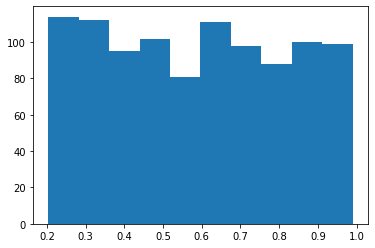

In [39]:
np.random.seed(42)
s = uniform(.2, .79).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

2
99


(array([111., 105., 104.,  95.,  84., 112.,  98.,  89.,  83., 119.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

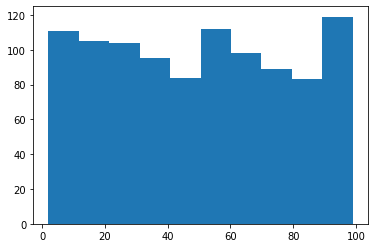

In [40]:
np.random.seed(42)
s = randint(2, 100).rvs(size=1000)
print(min(s))
print(max(s))
plt.hist(s)

In [41]:
s = randint(2, 20)

In [42]:
model_param_dict = [
    {
        'preparation__numeric_pipeline__impute_chooser__base_transformer': [SimpleImputer(strategy='mean')],
        'preparation__numeric_pipeline__scaling_chooser__base_transformer': [MinMaxScaler(), StandardScaler()],
        'preparation__non_numeric_pipeline__encoder_chooser__base_transformer': [OneHotEncoder(),
                                                                                 hlp.sklearn.CustomOrdinalEncoder()],
        'model__n_estimators': randint(50, 5000),
        # If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
        'model__max_features':  uniform(.01, .99),
    },
]

In [43]:
num_folds = 5
num_repeats = 2

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
random_search = RandomizedSearchCV(estimator=full_pipeline,
                                 param_distributions=model_param_dict,
                                 n_iter=30,
                                 cv=RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats),
                                 scoring='roc_auc',
                                 #return_train_score=True,
                                 n_jobs=-1,
                                 #verbose=2,
                                 random_state=42,
                                )
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preparation',
                                              ColumnTransformer(transformers=[('numeric_pipeline',
                                                                               Pipeline(steps=[('impute_chooser',
                                                                                                TransformerChooser()),
                                                                                               ('scaling_chooser',
                                                                                                TransformerChooser())]),
                                                                               ['duration',
                                                                                'credit_amount',
                                                                                'installment_commitme

## Results

In [45]:
random_search_df = hlp.sklearn.cv_results_to_dataframe(searcher=random_search,
                                                       num_folds=num_folds,
                                                       num_repeats=num_repeats,
                                                       return_style=False)

In [46]:
column_new_names = {'preparation | non_numeric_pipeline | encoder_chooser | base_transformer': 'transformer | encoder',
                    'preparation | numeric_pipeline | impute_chooser | base_transformer': 'transformer | imputer',
                    'preparation | numeric_pipeline | scaling_chooser | base_transformer': 'transformer | scaler'}
random_search_df.rename(columns=column_new_names, inplace=True)

In [47]:
random_search_df.head()

,roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,transformer | encoder,transformer | imputer,transformer | scaler
26,0.761787,0.739079,0.784495,0.025480,2618,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
19,0.761054,0.739020,0.783088,0.193006,4848,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
6,0.760692,0.738672,0.782712,0.191570,4605,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
15,0.759128,0.736083,0.782172,0.248615,1528,CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
4,0.758984,0.735117,0.782851,0.030379,819,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()


In [48]:
hlp.sklearn.cv_results_to_dataframe(searcher=random_search,
                                    num_folds=num_folds,
                                    num_repeats=num_repeats,
                                    return_style=True)

roc_auc Mean,roc_auc 95CI.LO,roc_auc 95CI.HI,model | max_features,model | n_estimators,preparation | non_numeric_pipeline | encoder_chooser | base_transformer,preparation | numeric_pipeline | impute_chooser | base_transformer,preparation | numeric_pipeline | scaling_chooser | base_transformer
0.762,0.739,0.784,0.025,"2,618",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.761,0.739,0.783,0.193,"4,848",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.761,0.739,0.783,0.192,"4,605",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.759,0.736,0.782,0.249,"1,528",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.759,0.735,0.783,0.030,819,CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.756,0.735,0.776,0.266,"3,993",CustomOrdinalEncoder(),SimpleImputer(),StandardScaler()
0.755,0.733,0.777,0.340,"2,969",CustomOrdinalEncoder(),SimpleImputer(),MinMaxScaler()
0.755,0.734,0.776,0.164,"4,476",OneHotEncoder(),SimpleImputer(),StandardScaler()
0.754,0.732,0.776,0.017,"2,954",OneHotEncoder(),SimpleImputer(),MinMaxScaler()
0.752,0.730,0.775,0.207,"1,545",OneHotEncoder(),SimpleImputer(),MinMaxScaler()


In [49]:
random_search_df.fillna(0).groupby('transformer | encoder').agg({'roc_auc Mean': np.mean}).sort_values(by='roc_auc Mean', ascending=False)

,roc_auc Mean
transformer | encoder,
CustomOrdinalEncoder(),0.750426
OneHotEncoder(),0.744166


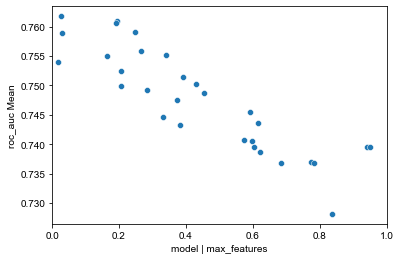

In [50]:
import matplotlib.pyplot as plt
plt.xlim(0, 1)
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df, x="model | max_features", y="roc_auc Mean")
plt.show()

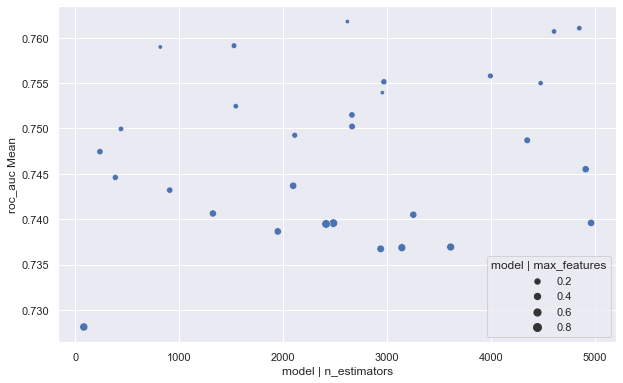

In [51]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.scatterplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                size='model | max_features')
plt.show()

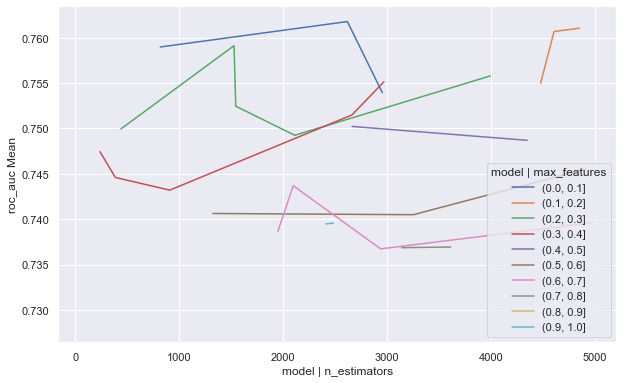

In [52]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.lineplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
                hue=pd.cut(random_search_df['model | max_features'], bins=np.linspace(0,1,11)))
plt.show()

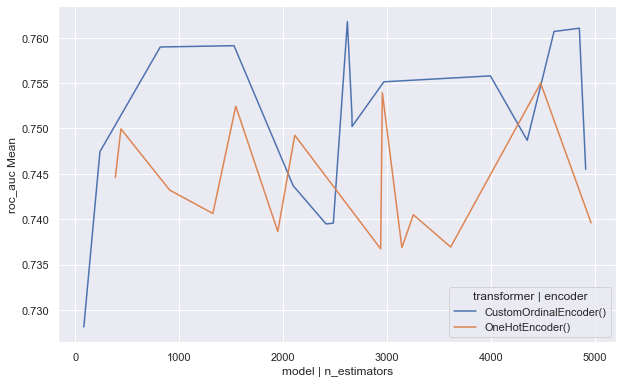

In [53]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.lineplot(data=random_search_df,
                x="model | n_estimators",
                y="roc_auc Mean",
             hue='transformer | encoder')
plt.show()

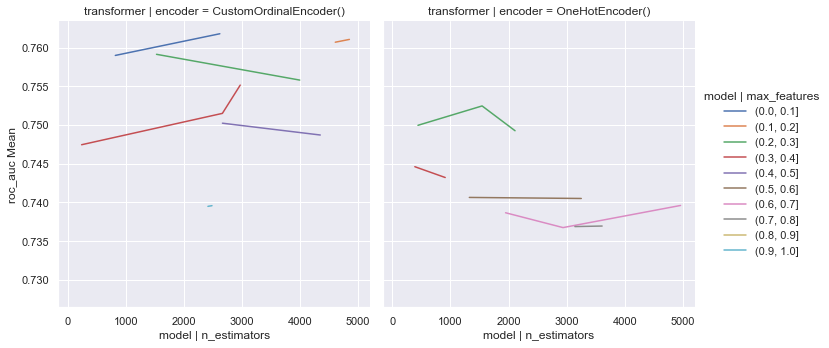

In [54]:
sns.set(rc={'figure.figsize': hlp.plot.STANDARD_WIDTH_HEIGHT})
sns.relplot(data=random_search_df,
            kind='line',
            x="model | n_estimators",
            y="roc_auc Mean",
            hue=pd.cut(random_search_df['model | max_features'], bins=np.linspace(0,1,11)),
            col='transformer | encoder')
plt.show()

# Test Set Evaluation

In [55]:
best_model = grid_search.best_estimator_

In [56]:
best_model.classes_

array([0, 1])

In [57]:
predicted_scores = best_model.predict_proba(X_test)[:, 1]

In [58]:
predicted_scores

array([0.602, 0.504, 0.278, 0.634, 0.942, 0.524, 0.916, 0.524, 0.82 ,
       0.766, 0.86 , 0.43 , 0.836, 0.322, 0.266, 0.67 , 0.876, 0.914,
       0.59 , 0.664, 0.778, 0.5  , 0.938, 0.992, 0.964, 0.576, 0.506,
       0.554, 0.742, 0.86 , 0.698, 0.79 , 0.582, 0.742, 0.894, 0.686,
       0.436, 0.814, 0.91 , 0.448, 0.618, 0.874, 0.63 , 0.908, 0.884,
       0.708, 0.476, 0.584, 0.616, 0.722, 0.43 , 0.924, 0.632, 0.54 ,
       0.776, 0.768, 0.91 , 0.416, 0.414, 0.88 , 0.74 , 0.464, 0.574,
       0.94 , 0.602, 0.756, 0.926, 0.59 , 0.552, 0.86 , 0.652, 0.92 ,
       0.834, 0.64 , 0.734, 0.49 , 0.594, 0.8  , 0.814, 0.46 , 0.822,
       0.788, 0.95 , 0.698, 0.818, 0.492, 0.33 , 0.328, 0.8  , 0.914,
       0.692, 0.938, 0.19 , 0.474, 0.952, 0.786, 0.844, 0.596, 0.334,
       0.546, 0.968, 0.65 , 0.804, 0.97 , 0.704, 0.718, 0.614, 0.55 ,
       0.806, 0.424, 0.316, 0.814, 0.668, 0.894, 0.664, 0.776, 0.616,
       0.906, 0.894, 0.604, 0.63 , 0.522, 0.77 , 0.808, 0.618, 0.77 ,
       0.42 , 0.812,

In [59]:
evaluator = hlp.sklearn.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

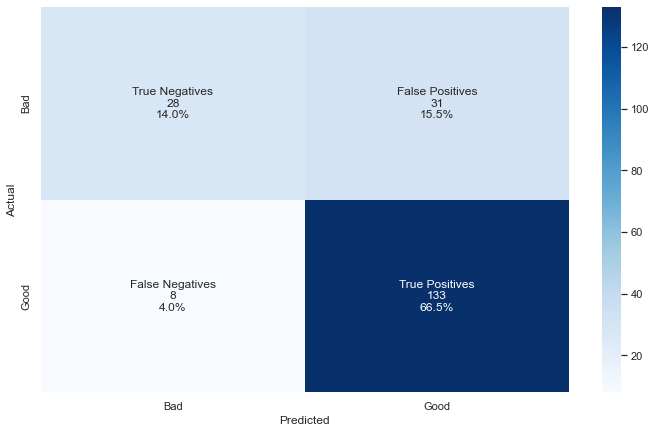

In [60]:
evaluator.plot_confusion_matrix()

In [61]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores
AUC,0.824
True Positive Rate,0.943
True Negative Rate,0.475
False Positive Rate,0.525
False Negative Rate,0.057
Positive Predictive Value,0.811
Negative Predictive Value,0.778
F1 Score,0.872
Kappa,0.471
Two-Class Accuracy,0.805


Compare results against scores if we predicted all `Good`

In [62]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [63]:
dummy_eval = hlp.sklearn.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores
AUC,0.500
True Positive Rate,1.000
True Negative Rate,0.000
False Positive Rate,1.000
False Negative Rate,0.000
Positive Predictive Value,0.705
Negative Predictive Value,0.000
F1 Score,0.827
Kappa,nan
Two-Class Accuracy,0.705


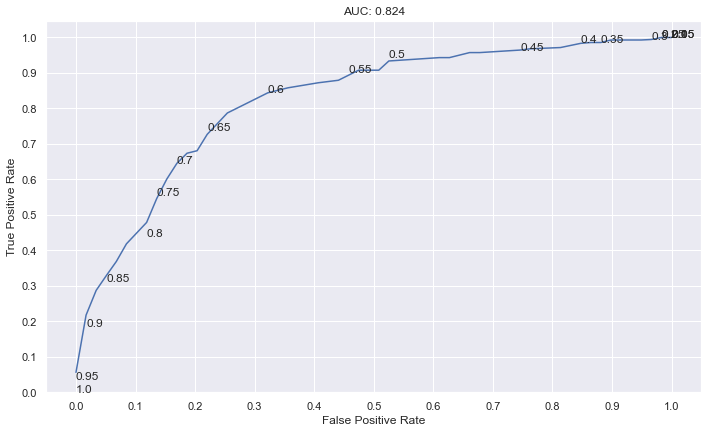

In [68]:
evaluator.plot_auc_curve()
plt.grid()

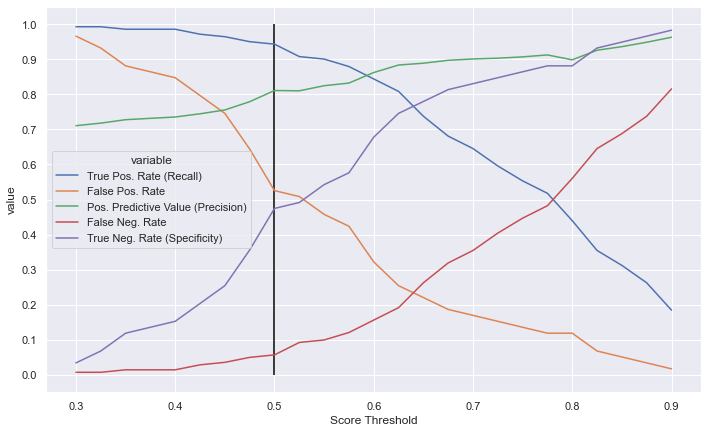

In [65]:
evaluator.plot_threshold_curves()
plt.grid()

In [66]:
evaluator.calculate_lift_gain(return_style=True)

,Gain,Lift
Percentile,,
5,0.07,1.42
10,0.14,1.42
15,0.19,1.28
20,0.27,1.35
25,0.33,1.33
30,0.40,1.32
35,0.44,1.26
40,0.52,1.29
45,0.57,1.28


todo: how to get features names out of final_estimator?

In [106]:
grid_search.best_estimator_._final_estimator.feature_importances_

array([0.07252194, 0.09931495, 0.03552747, 0.03337564, 0.08396358,
       0.01891117, 0.00949275, 0.01745772, 0.03705637, 0.006142  ,
       0.03794733, 0.00487061, 0.01085807, 0.02112202, 0.00827797,
       0.01415972, 0.01521401, 0.00994622, 0.00258998, 0.00991392,
       0.01329132, 0.02020563, 0.00211851, 0.0150982 , 0.00434104,
       0.00091095, 0.00870406, 0.00923194, 0.00696273, 0.01885996,
       0.00548358, 0.01272907, 0.01593863, 0.01131855, 0.01388117,
       0.0130887 , 0.01000111, 0.01497349, 0.00642938, 0.00805252,
       0.0154965 , 0.00613058, 0.00752342, 0.01034062, 0.01461837,
       0.01321648, 0.01288143, 0.01483003, 0.01390036, 0.01533828,
       0.00511287, 0.0083345 , 0.01714532, 0.0109433 , 0.01243262,
       0.01501963, 0.0021942 , 0.01047287, 0.01454793, 0.01394642,
       0.00273716, 0.00255311])

# TODO

- decide between imputing missing values and removing missing data; via tuning parameter(s)

- get feature importance for model that has various transformations (would have to build pipeline manually based on selected transformers since transformers are being tuned via grid-search)
    - https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
    - https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
   
```
grid_search.best_estimator_._final_estimator.feature_importances_
grid_search.best_estimator_._final_estimator.feature_importances_.shape
```

right now we can get importances but can't get feature names since it is being

- future importance
    - https://www.kaggle.com/general/175075
        - LOFO (Leave one feature out) for feature importance.
    - https://explained.ai/rf-importance/